```
補助本「ゼロから作るDeep Learning」
3章～7章までを輪読会の補足として、読んで行きます。
Eli Kaminuma 2018.1.31
```

### 補助本6章 [2018.4.12]
# 6章　学習に関するテクニック
  
- 目次
```
6.4 正則化
6.4.1 過学習
6.4.2 Weight decay
6.4.3 Dropout
6,5 ハイパーパラメータの検証
6.5.1 検証データ
6.5.2 ハイパーパラメータの最適化
6.5.3 ハイパーパラメータ最適化の実装
```


### 6.4 正則化
- 機械学習の問題では、過学習（overfitting）が問題になる
- 過学習とは
  - 訓練データだけに適応しすぎる
  - 訓練データにない他データにうまく対応できない状態
- 機械学習は汎化性能を目指す
  - まだ見ぬデータも正しく識別できるモデルが良い

### 6.4.1 過学習
-　過学習が起きる原因
  - ● パラメータを大量に持ち、表現力の高いモデルである
  - ● 訓練データが少ない
  
- わざと過学習を発生させる。
   - MNIST訓練データを本来60,000 個から300 個に限定
   - ネットワークの複雑性を高め7 層
   - 各層のニューロンの個数は100 個、活性化関数はReLU
- 該当ファイルはch06/overfit_weight_decay.py


In [1]:
#前準備
import numpy as np
import sys, os, time
from collections import OrderedDict # 順序付きDict
import matplotlib.pyplot as plt

sys.path.append(os.pardir) # load_mnistするために親ディレクトリを追加。必要に応じて変更 or dataset.mnistを別途import
from dataset.mnist import load_mnist

In [2]:
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [3]:
## これまでの章で使った関数のインポート。 
## 本来は下記の2つのインポート文でも良いが、参照しやすいように記載
# from common.layers import *
# from common.gradient import numerical_gradient

# 3.2 章
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

# 4.4章より, 微分を使った勾配算出用 
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 値を元に戻す
        it.iternext()   
        
    return grad

# 3章より
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

# 4章より
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [4]:
# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

In [5]:
import os
import sys
import numpy as np
sys.path.append('../')
from saitobook.common.multi_layer_net import MultiLayerNet
from saitobook.common.optimizer import *

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100,100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 学習係数0.01 のSGD でパラメータ更新
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100
train_loss_list = []
train_acc_list = []
test_acc_list = []
iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
            

print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

      

epoch:201, train acc:1.0, test acc:0.7793


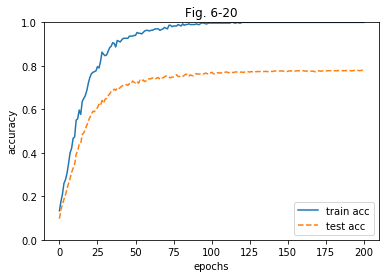

In [6]:
# グラフの描画

import matplotlib.pylab as plt
import numpy as np

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title('Fig. 6-20')
plt.show()

#### 過学習 vs 汎化
- train_acc_list、test_acc_list 
    - エポック単位
    - 訓練データを見終わった単位の認識精度が格納
-（train_acc_list、test_acc_list）をグラフとして描画
    - 結果は図6-20  
    - 認識精度(train)は、100 エポック以上でほぼ100% 
    - 認識精度(test)は低い
- 認識精度のtrain-test間の大きな隔たり
    - 訓練データだけに適応しすぎてしまった結果
    - <b>汎化性能</b>が低い＝汎用データ（test）へ適応できず



***

### 6.4.2 Weight decay

- <b>Weight decay（荷重減衰）</b>
   - 過学習抑制でよく用いられる手法
   - 大きな重みを持つことに対してペナルティを課す
   - 過学習は、重みパラメータが大きな値を取ることが原因の場合が多い
   - 損失関数の値を小さくする
       - たとえば、重みの2 乗ノルム（L2 ノルム）を損失関数に加算
       - 重みが大きくなることを抑制
   - Weight decay　$\frac{1}{2}\lambda W^{2}$
       - W = 重み
       - $\lambda$ = 正則化の強さをコントロールするハイパーパラメータ
       - $\lambda$を大きく設定すれば、重みを取ることに対して
           強いペナルティを課す
       - $\frac{1}{2}$ = $\frac{1}{2}\lambda W^{2}$の微分の結果を$\lambda W$ にするための調整用の定数
       
   - 全ての重みに$\frac{1}{2}\lambda W^{2}$を損失関数に加算
   - 重みの勾配計算
       - これまでの誤差逆伝播法による結果に、正則化項の微分$\lambda W$を加算

#### 正則化項

- L2 ノルムは、各要素の2 乗和に対応
- 重 み : $W = (w_{1},w_{2}, ·  ,w_{n})$ 
- L2ノルム = $sqrt(w_{1}^{2} + w_{2}^{2} +...+w_{n}^{2})$
- L2 ノルムの他
    - L1ノルム = $|w_{1}|+|w_{2}|+...+|w_{n}|$
    - L∞ノルム = 各要素の絶対値の中で最大のもの

- ここでは一般的によく用いられるL2ノルムだけを実装(図6-21)
- common/multi_layer_net.py
- ch06/overfit_weight_decay.py

epoch:0, train acc:0.12, test acc:0.1258
epoch:1, train acc:0.14, test acc:0.1411
epoch:2, train acc:0.14666666666666667, test acc:0.1431
epoch:3, train acc:0.15, test acc:0.1567
epoch:4, train acc:0.16666666666666666, test acc:0.1655
epoch:5, train acc:0.18, test acc:0.1727
epoch:6, train acc:0.21, test acc:0.1837
epoch:7, train acc:0.21333333333333335, test acc:0.1865
epoch:8, train acc:0.24666666666666667, test acc:0.195
epoch:9, train acc:0.25, test acc:0.2037
epoch:10, train acc:0.28, test acc:0.2125
epoch:11, train acc:0.31333333333333335, test acc:0.2301
epoch:12, train acc:0.3566666666666667, test acc:0.2436
epoch:13, train acc:0.3933333333333333, test acc:0.2705
epoch:14, train acc:0.4066666666666667, test acc:0.2878
epoch:15, train acc:0.4266666666666667, test acc:0.3085
epoch:16, train acc:0.4533333333333333, test acc:0.3332
epoch:17, train acc:0.4766666666666667, test acc:0.3554
epoch:18, train acc:0.5133333333333333, test acc:0.3768
epoch:19, train acc:0.53, test acc:0.392

epoch:158, train acc:0.8733333333333333, test acc:0.7212
epoch:159, train acc:0.8766666666666667, test acc:0.725
epoch:160, train acc:0.88, test acc:0.7262
epoch:161, train acc:0.8833333333333333, test acc:0.7272
epoch:162, train acc:0.8933333333333333, test acc:0.7319
epoch:163, train acc:0.8833333333333333, test acc:0.7322
epoch:164, train acc:0.8833333333333333, test acc:0.7254
epoch:165, train acc:0.8966666666666666, test acc:0.7317
epoch:166, train acc:0.8833333333333333, test acc:0.7231
epoch:167, train acc:0.8866666666666667, test acc:0.7303
epoch:168, train acc:0.88, test acc:0.7218
epoch:169, train acc:0.8833333333333333, test acc:0.73
epoch:170, train acc:0.8966666666666666, test acc:0.7419
epoch:171, train acc:0.8966666666666666, test acc:0.74
epoch:172, train acc:0.88, test acc:0.7344
epoch:173, train acc:0.8933333333333333, test acc:0.728
epoch:174, train acc:0.8866666666666667, test acc:0.7321
epoch:175, train acc:0.8933333333333333, test acc:0.7345
epoch:176, train acc:0

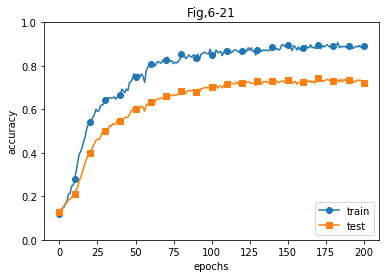

In [7]:
## 導入方法：weight_decay_lambda=weight_decay_lambda
##  順伝播：0,5*self.weight_decay_lambda*np.sum(W**2)
## 逆伝播： (lambda * W )

# coding: utf-8
import os
import sys

sys.path.append('../')  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from saitobook.common.multi_layer_net import MultiLayerNet
from saitobook.common.optimizer import SGD


# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（荷重減衰）の設定 =======================
#weight_decay_lambda = 0 # weight decayを使用しない場合
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title('Fig,6-21')
plt.show()

### 6.4.3 Dropout

- 過学習抑制のWeight Decayの問題
   - Weight decay=損失関数に対して重みのL2 ノルムを加算
   - モデルが複雑になるとWeight decayは対応が困難になる。
- 過学習抑制には<b>Dropout[14] 手法</b>がよく用いられる
   - Dropout はニューロンをランダムに消去しながら学習する手法
   - 訓練時に隠れ層のニューロンをランダムに選出して消去
   - 消去ニューロンは、信号の伝達が行われない(図6-22 )
   - テスト時には全ニューロン計算も<u>訓練時の消去割合を乗算</u>して出力


#### Dropoutの実装
- 特徴
    - 順伝播のたびにself.maskに消去ニューロンをFalseで格納
        - self.mask はxと同形状配列をランダムに生成
        - ランダム値が<u>dropout_ratio よりも大きい要素だけをTrueとする</u>
    - 逆伝播の際の挙動はReLU と同じ
        - 順伝播で信号を通したニューロンは、逆伝播の際に伝わる信号をそのまま通す
        - 順伝播で信号を通さなかったニューロンは、逆伝播では信号がストップ
    - 以降でDropoutの効果を確かめるために、MNIST データセットで検証
        - ソースコードはch06/overfit_dropout.py 
        - Trainerクラスを利用して実装簡略化
    - 7 層ネットワーク（各層のニューロンの個数は100 個、活性化関数はReLU）
         - 片方にはDropout適用、もう片方にはDropout を使用しない
         - 結果図6-23
         - Dropoutで訓練データとテストデータの認識精度の隔たり小さく
         - 訓練データが100% の認識精度に到達することもなくなる（過学習抑制）


In [8]:
#### Trainer.pyの中身
# coding: utf-8
import sys, os
#sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from saitobook.common.optimizer import *

class Trainer:
    """ニューラルネットの訓練を行うクラス
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


train loss:2.2983773533733474
=== epoch:1, train acc:0.1, test acc:0.0914 ===
train loss:2.29541878750506
train loss:2.3154481528346325
train loss:2.344262193849066
=== epoch:2, train acc:0.10666666666666667, test acc:0.0968 ===
train loss:2.3204846950992883
train loss:2.2913937228211143
train loss:2.304509346159207
=== epoch:3, train acc:0.12, test acc:0.1041 ===
train loss:2.328238665969377
train loss:2.2987441510551645
train loss:2.3081551362400305
=== epoch:4, train acc:0.12333333333333334, test acc:0.1159 ===
train loss:2.3104913885256217
train loss:2.29659504034014
train loss:2.290787673517686
=== epoch:5, train acc:0.13333333333333333, test acc:0.1215 ===
train loss:2.3188628277443906
train loss:2.295529818200188
train loss:2.2637998596685436
=== epoch:6, train acc:0.14666666666666667, test acc:0.132 ===
train loss:2.2890342512415685
train loss:2.2793699082397025
train loss:2.2942650123530584
=== epoch:7, train acc:0.16666666666666666, test acc:0.1424 ===
train loss:2.3003187283

=== epoch:57, train acc:0.24333333333333335, test acc:0.2054 ===
train loss:2.2011013587788533
train loss:2.202878659902505
train loss:2.197609112468784
=== epoch:58, train acc:0.24333333333333335, test acc:0.2057 ===
train loss:2.1873710037738845
train loss:2.212730579678651
train loss:2.1870679554735704
=== epoch:59, train acc:0.24333333333333335, test acc:0.2067 ===
train loss:2.2238312155883433
train loss:2.2067761657164473
train loss:2.191031884063711
=== epoch:60, train acc:0.24666666666666667, test acc:0.2075 ===
train loss:2.2062941952436645
train loss:2.1666399057331587
train loss:2.1907601437681627
=== epoch:61, train acc:0.24666666666666667, test acc:0.2079 ===
train loss:2.1748644811023614
train loss:2.1384893593561984
train loss:2.1556453238027298
=== epoch:62, train acc:0.24666666666666667, test acc:0.2048 ===
train loss:2.1414799790537513
train loss:2.202593889071415
train loss:2.1345823902546748
=== epoch:63, train acc:0.24666666666666667, test acc:0.2045 ===
train loss

=== epoch:113, train acc:0.33, test acc:0.2615 ===
train loss:1.936097935242457
train loss:2.050682472472182
train loss:1.9807773835885762
=== epoch:114, train acc:0.33, test acc:0.2615 ===
train loss:1.9879862000662667
train loss:2.0178493706315295
train loss:2.087769841205029
=== epoch:115, train acc:0.3333333333333333, test acc:0.263 ===
train loss:2.0896590974485822
train loss:1.9898942370131931
train loss:2.0397113432342358
=== epoch:116, train acc:0.33666666666666667, test acc:0.2637 ===
train loss:1.8997413613430356
train loss:1.9611846668757713
train loss:1.9974416089155207
=== epoch:117, train acc:0.33, test acc:0.2605 ===
train loss:1.9289347177141096
train loss:2.086232848496385
train loss:2.037552241985765
=== epoch:118, train acc:0.3333333333333333, test acc:0.2637 ===
train loss:2.0998821378075347
train loss:1.9865751417759645
train loss:2.039674473941974
=== epoch:119, train acc:0.34, test acc:0.2676 ===
train loss:1.998944593362514
train loss:1.9237626925298819
train lo

=== epoch:169, train acc:0.3933333333333333, test acc:0.3247 ===
train loss:1.7785273883489867
train loss:1.7601762139198538
train loss:1.7668995807871304
=== epoch:170, train acc:0.41, test acc:0.3283 ===
train loss:1.955907661337071
train loss:1.8420334816304753
train loss:1.8813158390390172
=== epoch:171, train acc:0.4166666666666667, test acc:0.333 ===
train loss:1.878493745718377
train loss:1.771954352719621
train loss:1.792785853971757
=== epoch:172, train acc:0.41333333333333333, test acc:0.3336 ===
train loss:1.8802397392071297
train loss:1.839068894848875
train loss:1.957319240881883
=== epoch:173, train acc:0.42, test acc:0.3412 ===
train loss:1.8438881482471448
train loss:1.857305793824296
train loss:1.5990632603216741
=== epoch:174, train acc:0.41333333333333333, test acc:0.3378 ===
train loss:1.7876939281070046
train loss:1.736479381560854
train loss:1.7392869527136818
=== epoch:175, train acc:0.41333333333333333, test acc:0.3365 ===
train loss:1.7207082173516843
train los

=== epoch:225, train acc:0.56, test acc:0.4358 ===
train loss:1.3915568324175798
train loss:1.5236033179585453
train loss:1.513853185728192
=== epoch:226, train acc:0.56, test acc:0.4397 ===
train loss:1.4874375300861329
train loss:1.5646918843372486
train loss:1.559151265447551
=== epoch:227, train acc:0.5766666666666667, test acc:0.4466 ===
train loss:1.515809836773829
train loss:1.3266842452782823
train loss:1.5150887770709118
=== epoch:228, train acc:0.57, test acc:0.4418 ===
train loss:1.5586866995394277
train loss:1.5967389353194408
train loss:1.4475426822853907
=== epoch:229, train acc:0.57, test acc:0.4434 ===
train loss:1.4128778146302432
train loss:1.6640803488487372
train loss:1.482440026712454
=== epoch:230, train acc:0.5666666666666667, test acc:0.4428 ===
train loss:1.5889948413834893
train loss:1.5709922124286695
train loss:1.4964897146655192
=== epoch:231, train acc:0.5833333333333334, test acc:0.4496 ===
train loss:1.5601211300809552
train loss:1.458404260787435
train 

=== epoch:280, train acc:0.6233333333333333, test acc:0.5234 ===
train loss:1.2112655434996287
train loss:1.060208829906273
train loss:1.3433193033990072
=== epoch:281, train acc:0.6233333333333333, test acc:0.5232 ===
train loss:1.2268317822981356
train loss:1.135710370235763
train loss:1.2192471441468322
=== epoch:282, train acc:0.6266666666666667, test acc:0.5214 ===
train loss:1.1411863519089953
train loss:1.2012004170692332
train loss:1.1702574955731435
=== epoch:283, train acc:0.6266666666666667, test acc:0.5229 ===
train loss:1.2612216922438784
train loss:1.2184325672540803
train loss:1.3301222167953264
=== epoch:284, train acc:0.6266666666666667, test acc:0.5292 ===
train loss:1.246122634567428
train loss:1.1611204939214839
train loss:1.1267010839293432
=== epoch:285, train acc:0.6266666666666667, test acc:0.5294 ===
train loss:1.162717609731534
train loss:1.1510134056014036
train loss:1.124095591778488
=== epoch:286, train acc:0.6266666666666667, test acc:0.529 ===
train loss:

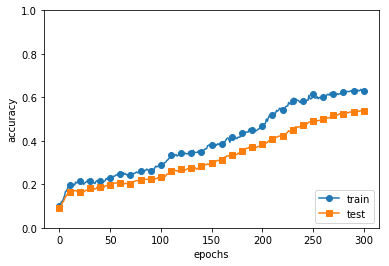

In [9]:
#
# class dropoutに実装
#
# coding: utf-8
import os
import sys
sys.path.append('../')  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from saitobook.common.multi_layer_net_extend import MultiLayerNetExtend
from saitobook.common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### Dropoutとアンサンブル学習

- アンサンブル学習
   - 複数のモデルを個別に学習させ、推論時には、その複数の出力を平均
   - アンサンブル学習を行うことで、ニューラルネットワークの認識精度が数%向上

- アンサンブル学習はDropout と近い関係
    - Dropoutは推論時には、ニューロン出力に消去割合（ex.0.5）を乗算
    - モデルの平均を取る
    - つまりDropout は、アンサンブル学習と同効果を（擬似的に）1ネットワークで実現

### 6.5 ハイパーパラメータの検証

- ハイパーパラメータ
    - 各層のニューロン数
    - バッチサイズ
    - 学習係数
    - Weight decay
- 適切な値にすると予測性能が向上する。
- 最適値の探索は試行錯誤が必要になる

#### 6.5.1 検証データ(validation data)

- 検証データ（validation data）とは
   - ハイパーパラメータ調整専用のデータ
　 - テストデータを使ってハイパーパラメータの性能を評価してはいけない
   - テストデータに対して過学習を起こすから
   - 訓練データは、パラメータ（重みやバイアス）の学習に使う
   
- データセットの種類別
   - 訓練データ・検証データ・テストデータの3種類＝＞検証データ使う
   - 訓練データ・テストデータの2種類＝＞自分で検証データ構築

- 検証データの作成方法
   - MNIST データセットの場合、検証データ作成方法
   - 訓練データの中から20% 程度を検証データとして分離

   


#### 6.5.3 ハイパーパラメータ最適化の実装





In [13]:
from saitobook.common.util import shuffle_dataset
# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
# 訓練データをシャッフル
x_train, t_train = shuffle_dataset(x_train, t_train)
# 検証データの分割
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

#### 6.5.2 ハイパーパラメータの最適化

- 最適化を行う上で重要なポイント
   -ハイパーパラメータの「良い値」範囲を徐々に絞り込んでいく  
   - 最初はおおまかに範囲を設定
   - その範囲の中からランダムにハイパーパラメータを選び出し（サンプリングし）
   - サンプリングした値で認識精度の評価
   - 複数回繰り返し、認識精度の結果を観察
   - 結果からハイパーパラメータの「良い値」の範囲を狭めていく
   
- ニューラルネットワークのハイパーパラメータの最適化手法
   - グリッドサーチ(規則的な探索)は使わない
   - ランダムにサンプリングして探索するほうが良い結果になる[15] 
   - 複数ハイパーパラメータのうち、認識精度に与える影響度がハイパーパラメータごとに異なるから

- 最適化の手順
　　- ステップ0＝ハイパーパラメータの範囲を設定する。
    - ステップ1＝設定されたハイパーパラメータの範囲から、ランダムにサンプリング
    - ステップ2＝ステップ1 でサンプリングされたハイパーパラメータの値を使用して学習を行い、検証データで認識精度を評価する（ただし、エポックは小さく設定）。
    - ステップ3＝ステップ1 とステップ2 をある回数（100 回など）繰り返し、それらの認識精度の結果から、ハイパーパラメータの範囲を狭める。

In [ ]:
# coding: utf-8
import sys, os
sys.path.append('../')  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from saitobook.common.multi_layer_net import MultiLayerNet
from saitobook.common.util import shuffle_dataset
from saitobook.common.trainer import Trainer

#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減　(＜＜時間がかかるので)
#x_train = x_train[:500]
#t_train = t_train[:500]

# 検証データの分離
#validation_rate = 0.20
#validation_num = x_train.shape[0] * validation_rate
#x_train, t_train = shuffle_dataset(x_train, t_train)
#x_val = x_train[:validation_num]
#t_val = t_train[:validation_num]
#x_train = x_train[validation_num:]
#t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()
